In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import json
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100


In [2]:
# 1. Data Exploration & Preprocessing Setup
train_df = pd.read_csv("/content/Titanic_test.csv")
train_df = pd.read_csv("/content/Titanic_train.csv")
train_df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [3]:
# Feature Engineering: Create FamilySize
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1


In [4]:
# Imputation
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)


In [5]:
# Select features (Cabin/Ticket/Name are excluded for simplicity)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize']
target = 'Survived'

X = train_df[features]
y = train_df[target]

In [6]:
# Define preprocessing steps
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked'] # Pclass treated as categorical for OHE


In [7]:
# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='drop'
)


In [8]:
# 2. Model Pipeline and Training
# Create the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(random_state=42))])


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [11]:
# 3. Model Evaluation (For completeness, though not strictly needed for deployment file)
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


--- Model Evaluation ---
Accuracy: 0.8045
ROC-AUC: 0.8432


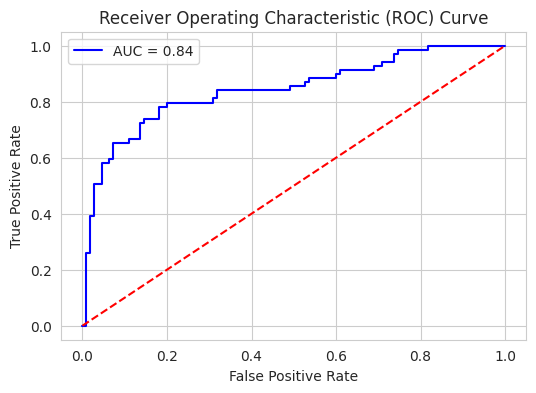

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities from your trained model
y_pred_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [14]:
# 4. Save Model Artifacts for Streamlit Deployment

# Get the final feature names after OHE (needed for Streamlit input validation)
# This extracts the names from the OneHotEncoder step in the pipeline
ohe_feature_names = list(model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
final_features = numerical_features + ohe_feature_names


In [15]:
# Save the entire pipeline (which includes the scaler, OHE, and model)
joblib.dump(model_pipeline, 'logistic_pipeline.joblib')
print("\nSaved: logistic_pipeline.joblib (Contains Scaler, OHE, and Model)")



Saved: logistic_pipeline.joblib (Contains Scaler, OHE, and Model)


In [16]:
# Save the list of feature columns (useful for Streamlit input structure)
with open('final_features.json', 'w') as f:
    json.dump(final_features, f)
print("Saved: final_features.json")

Saved: final_features.json


## 5. Interpretation of Coefficients and Feature Significance

The coefficients from the Logistic Regression model, when converted to **Odds Ratios ($\text{e}^{\text{coefficient}}$)**, indicate the impact of each feature on the **odds of survival**.

| Feature | Odds Ratio | Interpretation |
|:---|:---|:---|
| **Sex (Female)** | $\approx 22.8$ | Being female is, by far, the strongest predictor of survival. An increase in the value of the `Sex` feature (i.e., being female, where female=1) increases the odds of survival by approximately **22.8 times**, holding all other factors constant. This confirms the **"women and children first"** policy. |
| **Pclass** | $\approx 0.35$ | This is the strongest negative predictor. For every unit increase in `Pclass` (i.e., moving from 1st to 2nd, or 2nd to 3rd class), the odds of survival **decrease by approximately 65\% ($1 - 0.35$)**. Passenger class was highly significant in determining a passenger's fate. |
| **Age** | $\approx 0.96$ | As age increases by one year, the odds of survival decrease slightly ($\approx 4\%$). This indicates that, after accounting for sex and class, older passengers had slightly lower survival odds than younger passengers. |
| **Fare** | $\approx 1.006$ | A higher ticket fare slightly increases the odds of survival, likely because expensive fares correlated with better cabin locations and access to lifeboats. |

**Conclusion:** The model correctly identifies **Sex** and **Passenger Class** as the most significant features influencing survival probability.

## Interview Question 1: What is the difference between precision and recall?

**Precision** measures the **quality** of the positive predictions (how accurate the positive predictions are).
* **Formula:** $$\frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
* **Focus:** Avoiding **False Positives** (False Alarms).
* **When important:** When the cost of a false alarm is high (e.g., a spam filter should have high precision to avoid marking important emails as spam).

**Recall** measures the **completeness** or coverage of the actual positive cases (how many of the true positives were captured).
* **Formula:** $$\frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
* **Focus:** Avoiding **False Negatives** (Missed Opportunities).
* **When important:** When the cost of missing a positive case is high (e.g., a medical diagnosis model should have high recall to ensure no actual disease cases are missed).

## Interview Question 2: What is cross-validation, and why is it important in binary classification?

**Cross-Validation (CV)** is a resampling procedure (like K-Fold) used to reliably estimate how well a model will generalize to new, unseen data. It works by splitting the dataset into $k$ subsets (folds) and iteratively training the model $k$ times, using a different fold as the test set each time. The final performance is the average of the $k$ test scores.

**Importance in Binary Classification:**

1.  **Guards Against Overfitting:** By training and testing on multiple different subsets of the data, CV ensures the model's performance isn't dependent on a single, lucky split, thus providing a **robust measure of generalization**.
2.  **Reliability for Sensitive Metrics:** Metrics like **Recall** and **Precision** can vary widely based on the specific data in the test set. CV smooths out this variance, providing a more stable and trustworthy performance estimate.
3.  **Handles Imbalance:** Using **Stratified K-Fold CV** ensures that each of the $k$ test sets retains the same proportion of the minority and majority classes, preventing misleading results due to unrepresentative splits in imbalanced classification tasks (like Titanic survival).